In [1]:
import sys
import os
import numpy as np
import multiprocessing
import dill
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from statsmodels.api import OLS, add_constant
import time
from scipy.stats import norm

from vax_sims_LHS_samples import *
from plot_utils import *

In [2]:
def load_sim_output(folder, npoints, lb=0):
    scenario_data = pd.DataFrame(columns=UNCERTAINTY_PARAMS+['student_inf_10','student_inf_50','student_inf_90']+\
                                ['staff_inf_10', 'staff_inf_50', 'staff_inf_90'])
    for idx in range(lb, npoints):
        inf_file = folder + '/list_of_infs_by_group_{}.dill'.format(idx)
        point_file = folder + '/lhs_point_{}.dill'.format(idx)
        with open(inf_file, 'rb') as fhandle:
            inf_matrix = np.array(dill.load(fhandle))
            student_infxns = np.sum(inf_matrix[:,:-2], axis=1)
            staff_infxns = np.sum(inf_matrix[:,-2:], axis=1)
        with open(point_file, 'rb') as fhandle:
            uncertainty_point = dill.load(fhandle)

        new_row = dict()
        for index, col_name in enumerate(UNCERTAINTY_PARAMS):
            if type(uncertainty_point) == dict:
                new_row[col_name] = uncertainty_point[col_name]
            else:
                new_row[col_name] = uncertainty_point[index]
        new_row['student_inf_10'] = np.quantile(student_infxns, 0.1)
        new_row['student_inf_50'] = np.quantile(student_infxns, 0.5)
        new_row['student_inf_90'] = np.quantile(student_infxns, 0.9)
        new_row['staff_inf_10'] = np.quantile(staff_infxns, 0.1)
        new_row['staff_inf_50'] = np.quantile(staff_infxns, 0.5)
        new_row['staff_inf_90'] = np.quantile(staff_infxns, 0.9)
        new_row['cornell_inf_10'] = np.quantile(student_infxns + staff_infxns, 0.1)
        new_row['cornell_inf_50'] = np.quantile(student_infxns + staff_infxns, 0.5)
        new_row['cornell_inf_90'] = np.quantile(student_infxns + staff_infxns, 0.9)
        
        scenario_data = scenario_data.append(new_row, ignore_index=True)

    return scenario_data

def residential_regression_student(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'student_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results

def residential_regression_staff(scenario_data):
    columns = scenario_data.columns[0:5]
    target = 'staff_inf_50'
    X_res = scenario_data[columns]
    Y_res_outcomes = np.array(scenario_data[[target]])

    X = add_constant(X_res)
    model = OLS(Y_res_outcomes,X)
    results = model.fit()
    return results


In [3]:
def calculate_pessimistic_scenario(results, q=0.99, beta=1.96):
    # the keys in dict(results.params) specify whether this is for residential
    # or virtual vs. residential
    lr_results = dict(results.params)
    sd_dict = dict()
    pess_direction = dict()
    params = set(lr_results.keys()) - set(['const'])
    centre_infections = lr_results['const']

    invquantile = norm.ppf(q)

    for param in params:
        sd_dict[param] = (UNCERTAINTY_PARAM_RANGES[param][1] - UNCERTAINTY_PARAM_RANGES[param][0])/(2*beta)
        centre_infections += np.mean(UNCERTAINTY_PARAM_RANGES[param]) * lr_results[param]

    sum_squares_Sigma_1 = 0

    for param in params:
        sum_squares_Sigma_1 += (lr_results[param]*sd_dict[param]) ** 2

    for param in params:
        pess_direction[param] = lr_results[param]*(sd_dict[param])**2 / np.sqrt(sum_squares_Sigma_1)

    mp_pess_scenario = dict()
    for param in params:
        mp_pess_scenario[param] = np.mean(UNCERTAINTY_PARAM_RANGES[param]) + invquantile * pess_direction[param]

    return mp_pess_scenario

In [4]:
LHS_data = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/lhs_vax_sims:1630458074.2074487', 200)

In [5]:
lr_results = residential_regression_student(LHS_data)
pess_scenario_student = calculate_pessimistic_scenario(lr_results)

In [6]:
def get_direction(pess, centre):
    direction = dict()
    for param in centre.keys():
        direction[param] = pess[param] - centre[param]
    return direction

def generate_new_params(centre, direction, mult):
    new_params = dict()
    for param in centre.keys():
        new_params[param] = centre[param] + mult * direction[param]
    return new_params

def launch_sensitivity_analysis(centre, direction, base_folder, mult_list=np.linspace(-1.1, 1.1, 23), nreps=50, param_modifiers=None):

    points = [generate_new_params(centre, direction, mult) for mult in mult_list]

#     folder_name = '{}/{}/'.format(base_folder, 'pess_sensitivity')
#     os.mkdir(folder_name)

#     fnames = [folder_name + 'mult_{}.dill'.format(mult) for mult in mult_list]

    #import pdb; pdb.set_trace()
    processes = run_sims_new_process(points, base_folder, nreps=nreps, param_modifiers=param_modifiers, wait_for_processes_to_join=False)
    return processes


def run_sims_new_process(points, output_folder, nreps=50, T=112, param_modifiers=None, wait_for_processes_to_join=True):
    idx = 0
    processes = []

    base_seed = np.random.randint(1000000, 10000000)

    for point in points:
        idx += 1
        p = run_new_process(point, idx, output_folder, param_modifiers)
        processes.append(p)

    print("launched {} processes".format(len(processes)))
    if wait_for_processes_to_join:
        for p in processes:
            p.join()
        print("done running processes")
        return processes
    else:
        return processes

def run_new_process(point, idx, output_folder, param_modifiers):
    p = Process(target = run_simulations, args = (point, idx, output_folder, param_modifiers))
    p.start()
    return p

def run_simulations(point, idx, output_folder, param_modifiers):
    T=112
    n=50
    if type(point) == dict:
        point = [point['vax_susc_mult'], point['vax_transmission_mult'], point['contacts_per_day_mult'], point['outside_infection_rate_mult'], point['cases_isolated_per_contact_trace']]
    vax_sim = map_lhs_point_to_vax_sim(point, param_modifiers)
    list_of_infs_by_group = run_multiple_trajectories(vax_sim, T, n)
    with open(output_folder + "lhs_point_{}.dill".format(idx), "wb") as f:
        dill.dump(point, f)
    with open(output_folder + "list_of_infs_by_group_{}.dill".format(idx), "wb") as f:
        dill.dump(list_of_infs_by_group, f)

def get_centre_point():
    centre = {}
    for param in UNCERTAINTY_PARAM_RANGES:
        lb, ub = UNCERTAINTY_PARAM_RANGES[param]
        centre[param] = (lb + ub) / 2
    return centre

def get_timestamp():
    return str(time.time()).split('.')[0]

In [7]:
MULT_RANGE = np.linspace(-1.1, 1.1, 23)

# pess_scenario_student
centre = get_centre_point()

direction = get_direction(pess_scenario_student, centre)

# toggle whether/not to use poisson contact tracing
os.environ['use_poisson_contact_tracing'] = 'True'

# base_folder = './aug_31_student_pess_sensitivity_sims_{}/'.format(get_timestamp())
base_folder = './aug_31_ct_sensitivity_sims_{}/'.format(get_timestamp())
os.mkdir(base_folder)

processes = []

# Test policies: [Vax students freq, Unvax students freq]
# 1: [0, 1/7]
# 2: [0, 2/7]
# 3: [1/7, 1/7]
# 4: [1/7, 2/7]
# 5: [2/7, 2/7]
# Nominal: [1/7, 2/7]

for ct_mult in [0, 0.25, 0.5, 0.75, 1, 1.25, 1.5]:
    ct_folder = base_folder + 'ct_{}/'.format(ct_mult)
    os.mkdir(ct_folder)
    ct_param_modifiers = {'ug_ga_vax_test_frequency': 2/7, 'ug_ga_unvax_test_frequency': 2/7,
            'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
            'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
            'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7,
            'cases_isolated_per_contact_mult': ct_mult}
    processes.extend(launch_sensitivity_analysis(centre, direction, ct_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=ct_param_modifiers))

# policy_7_folder = base_folder + 'ct_0/'
# os.mkdir(policy_7_folder)
# test_policy_7 = {'ug_ga_vax_test_frequency': 2/7, 'ug_ga_unvax_test_frequency': 2/7,
#             'ug_other_vax_test_frequency': 1/7, 'ug_other_unvax_test_frequency': 2/7,
#             'grad_vax_test_frequency': 1/7, 'grad_unvax_test_frequency': 2/7,
#             'employee_vax_test_frequency': 1/7, 'employee_unvax_test_frequency': 2/7}
# processes.extend(launch_sensitivity_analysis(centre, direction, policy_7_folder, mult_list = MULT_RANGE, nreps=100, param_modifiers=test_policy_7))


# for mult in MULT_RANGE:
#for param in PARAMS_LIST:

print("finished launching processes, waiting for them to finish")
for p in processes:
    p.join()

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load

/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_para

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  para

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

launched 23 processes


/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = ya

/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:136: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_sev_params = yaml.load(f)
/home/aaj54/group-testing/src/simulations_v2/load_params.py:45: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  age_s

launched 23 processes
finished launching processes, waiting for them to finish


In [8]:
ct_0 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_ct_sensitivity_sims_1630619389/ct_0', 24, lb=1)
ct_25 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_ct_sensitivity_sims_1630619389/ct_0.25', 24, lb=1)
ct_50 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_ct_sensitivity_sims_1630619389/ct_0.5', 24, lb=1)
ct_75 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_ct_sensitivity_sims_1630619389/ct_0.75', 24, lb=1)
ct_100 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_ct_sensitivity_sims_1630619389/ct_1', 24, lb=1)
ct_125 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_ct_sensitivity_sims_1630619389/ct_1.25', 24, lb=1)
ct_150 = load_sim_output('/home/aaj54/group-testing/notebooks/vax_sims/aug_31_ct_sensitivity_sims_1630619389/ct_1.5', 24, lb=1)

for df in (ct_0, ct_25, ct_50, ct_75, ct_100, ct_125, ct_150):
    df['mult'] = np.linspace(-1.1, 1.1, 23)
    df['z-score'] = [norm.ppf(0.99) * x for x in np.linspace(-1.1, 1.1, 23)]
    df['quantile'] = [norm.cdf(norm.ppf(0.99) * x) for x in np.linspace(-1.1, 1.1, 23)]

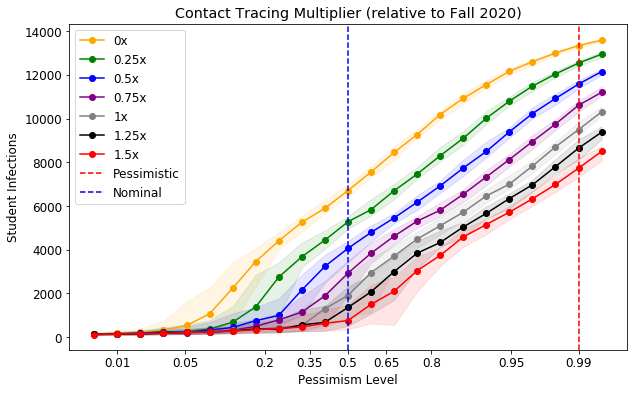

In [11]:
plt.figure(figsize=(10,6))

plt.plot('z-score', 'student_inf_50', marker='o', data=ct_0, label='0x', color='orange')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=ct_0, color='orange')

plt.plot('z-score', 'student_inf_50', marker='o', data=ct_25, label='0.25x', color='green')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=ct_25, color='green')

plt.plot('z-score', 'student_inf_50', marker='o', data=ct_50, label='0.5x', color='blue')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=ct_50, color='blue')

plt.plot('z-score', 'student_inf_50', marker='o', data=ct_75, label='0.75x', color='purple')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=ct_75, color='purple')

plt.plot('z-score', 'student_inf_50', marker='o', data=ct_100, label='1x', color='gray')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=ct_100, color='gray')

plt.plot('z-score', 'student_inf_50', marker='o', data=ct_125, label='1.25x', color='black')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=ct_125, color='black')

plt.plot('z-score', 'student_inf_50', marker='o', data=ct_150, label='1.5x', color='red')
plt.fill_between(x='z-score', y1='student_inf_10', y2='student_inf_90', alpha=0.1, data=ct_150, color='red')

plt.title('Contact Tracing Multiplier (relative to Fall 2020)')
plt.ylabel('Student Infections')
plt.xlabel('Pessimism Level')

plt.axvline(norm.ppf(0.99), label='Pessimistic', color='red', linestyle = 'dashed')
plt.axvline(0, label='Nominal', color='blue', linestyle = 'dashed')

plotting_quantiles = [0.01, 0.05, 0.2, 0.35, 0.5, 0.65, 0.8, 0.95, 0.99]
plt.xticks([norm.ppf(x) for x in plotting_quantiles], plotting_quantiles)

plt.legend()

plt.show()